# ECSE 415: Assignment 3
## Segmentation & Stereo Vision
### Author: Antonios Valkanas

### Question 2.2 Epipolar Geometry

In [1]:
import cv2
import numpy as np
from copy import deepcopy
from skimage import segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt

# Load Images
imgl = cv2.imread("im0.png", cv2.IMREAD_COLOR)
imgr = cv2.imread("im1.png", cv2.IMREAD_COLOR)
imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)

### Question 2.2 (a)
* Compute matching SIFT keypoints from a stereo image pair.

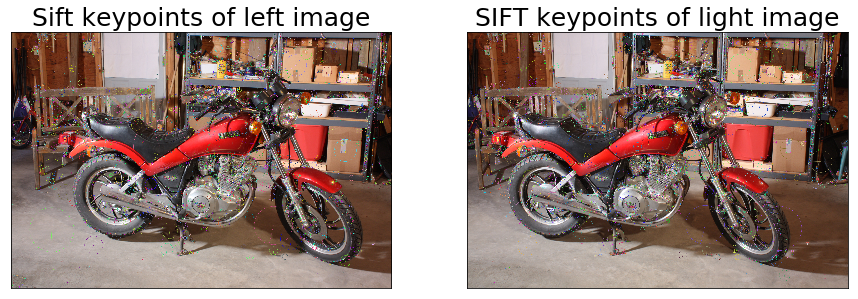

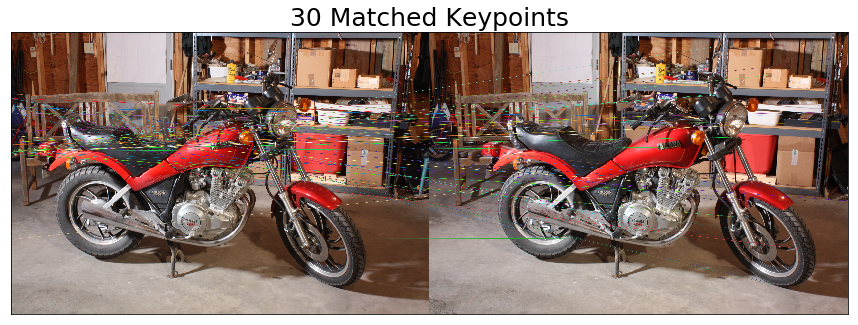

In [2]:
# SIFT KEYPOINTS
# Code from tutorial 6
sift = cv2.xfeatures2d.SIFT_create()

# Find descriptors and keypoints
kpl, desl = sift.detectAndCompute(imgl, None)
kpr, desr = sift.detectAndCompute(imgr, None)

# Copy images for displaying
displ = imgl.copy()
dispr = imgr.copy()

# Display keypoints
cv2.drawKeypoints(imgl, kpl, displ, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(imgr, kpr, dispr, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(displ)
plt.title("Sift keypoints of left image", fontsize = 25), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(dispr)
plt.title("SIFT keypoints of light image", fontsize = 25), plt.xticks([]), plt.yticks([])
plt.show()

# Create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# Match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desl, desr, k=2)

# Draw 30 matches
imgmatch = cv2.drawMatchesKnn(imgr,kpr,imgl,kpl, matches[:30], imgr, flags=2)

plt.figure(figsize=(15,15))
plt.imshow(imgmatch)
plt.title("30 Matched Keypoints", fontsize = 25), plt.xticks([]), plt.yticks([])
plt.show()

### Question 2.2 (b)
* Compute and display the epipolar lines for both images.

In [3]:
# Compute epipolar lines
# Code from tutorial 6

""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    row, col, ch = img1.shape
    # Copy input images
    img_draw = img1.copy()
    img_pts = img2.copy()
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img_draw = cv2.line(img_draw, (x0,y0), (x1,y1), color, 3)
        img_draw = cv2.circle(img_draw, tuple(pt1), 10, color, 10)
        img_pts = cv2.circle(img_pts, tuple(pt2), 10, color, 10)
    return img_draw, img_pts

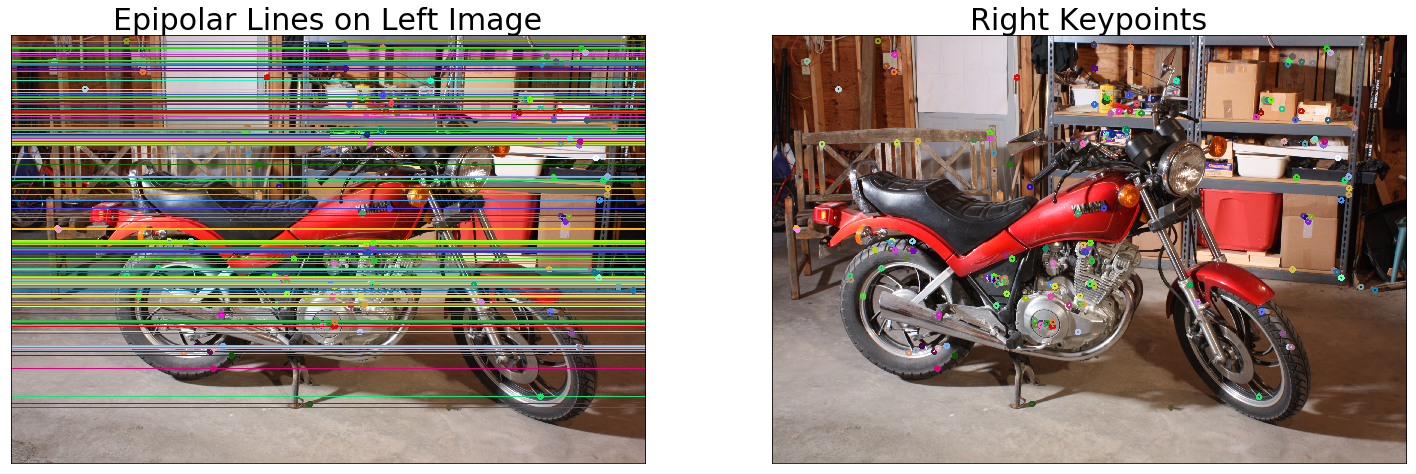

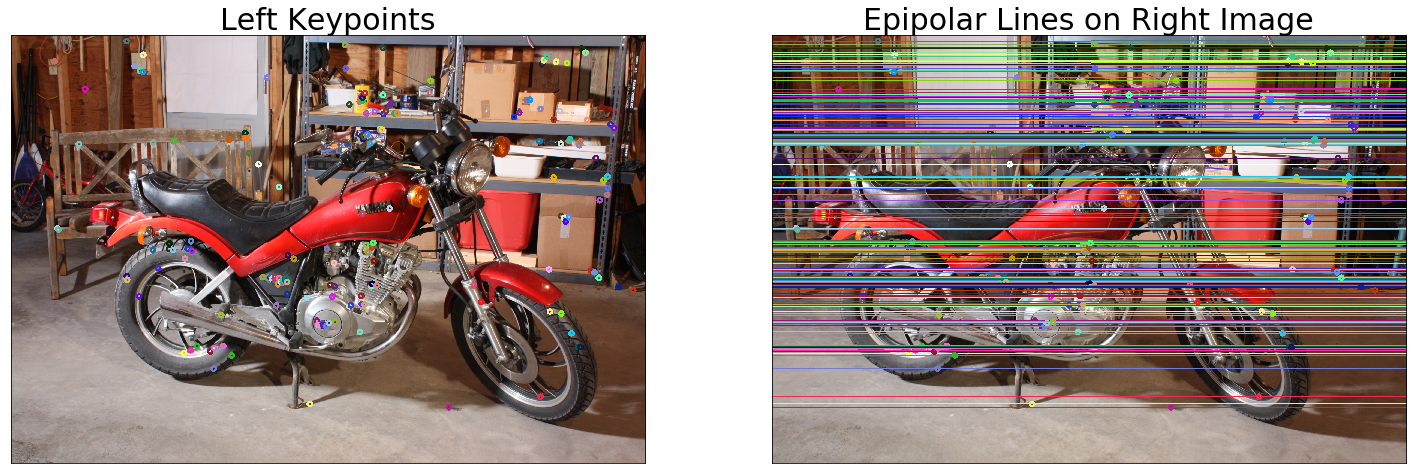

In [4]:
# ratio test - store the list of best matches from both images
good = []
good_left_points = []
good_right_points = []

# ratio test - store the list of bad matches from both images
bad = []
bad_points_left = []
bad_points_right = []

RATIO = 0.2

for i, (m, n) in enumerate(matches):
    if m.distance < RATIO * n.distance:
        good.append(m)
        good_right_points.append(kpr[m.trainIdx].pt)
        good_left_points.append(kpl[m.queryIdx].pt)
    elif m.distance > (1 - RATIO) * n.distance:
        bad.append(m)
        bad_points_right.append(kpr[m.trainIdx].pt)
        bad_points_left.append(kpl[m.queryIdx].pt)

# Find the Fundamental Matrix
good_left_points = np.int32(good_left_points)
good_right_points = np.int32(good_right_points)
F, mask = cv2.findFundamentalMat(good_left_points, good_right_points, cv2.FM_LMEDS)

# Use only inliers for remaining computations
good_left_points = good_left_points[mask.ravel()==1]
good_right_points = good_right_points[mask.ravel()==1]

# Find Epipolar lines for left
linesl = cv2.computeCorrespondEpilines(good_right_points, 2, F)
linesl = linesl.reshape(-1, 3)
# Draw Epipolar lines on left
imgl1, imgr1 = drawlines(imgl, imgr, linesl, good_left_points, good_right_points)

# Find Epipolar lines for right
linesr = cv2.computeCorrespondEpilines(good_left_points, 1, F)
linesr = linesr.reshape(-1, 3)
# Draw Epipolar lines on right
imgr2, imgl2 = drawlines(imgr, imgl, linesr, good_right_points, good_left_points)

# Display images
plt.figure(figsize=(25,25))
plt.subplot(121), plt.imshow(imgl1)
plt.title("Epipolar Lines on Left Image", fontsize = 30), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgr1)
plt.title("Right Keypoints", fontsize = 30), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(25,25))
plt.subplot(121), plt.imshow(imgl2)
plt.title("Left Keypoints", fontsize = 30), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgr2)
plt.title("Epipolar Lines on Right Image", fontsize = 30), plt.xticks([]), plt.yticks([])
plt.show()

### Question 2.2 (c)
Pick any one keypoint in the right image which doesn't have a correct
match in the left image, and is not on the corresponding epipolar line.
Extract a patch of size (5 x 5) around this keypoint in the right image.

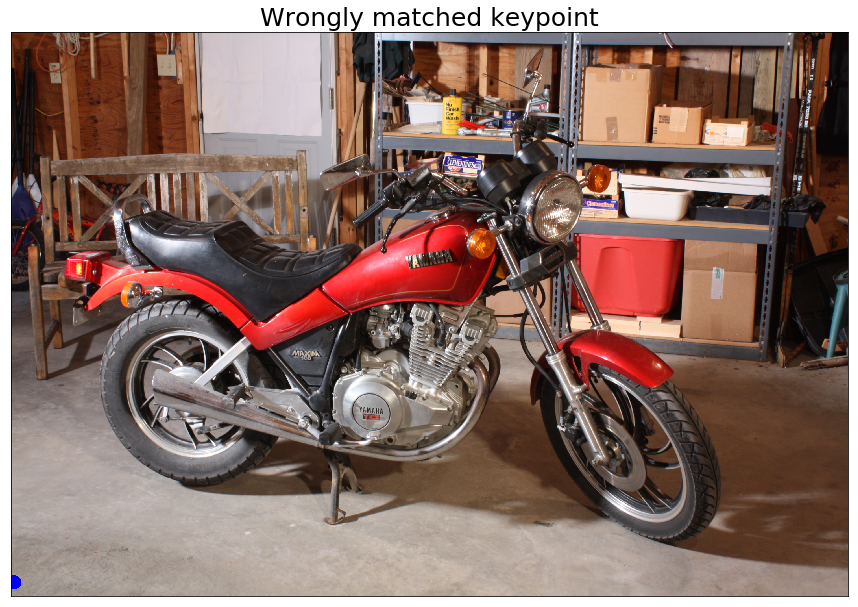

In [10]:
# Choosing a mismatched kp
keypoint = bad_points_left[10]
x = int(keypoint[0])
y = int(keypoint[1])

# Display the kp on right image
disp_keypointr = imgr.copy()
cv2.circle(disp_keypointr, (x, y), 25, [0,0,255], -1)
plt.figure(figsize=(15, 15))
plt.imshow(disp_keypointr)
plt.title("Wrongly matched keypoint", fontsize = 25), plt.xticks([]), plt.yticks([])
plt.show()

Text(0.5,1,'5x5 Patch around Mismatched Keypoint')

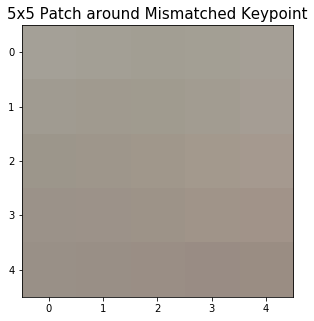

In [6]:
# Extract 5x5 patch
patch = imgr[y-2:y+3, x-2:x+3]

# Display images
plt.figure(figsize=(5,5))
plt.imshow(patch)
plt.title("5x5 Patch around Mismatched Keypoint", fontsize = 15)

### Question 2.2 (d)
Match the extracted patch using the sum of squared difference (SSD) with every patch along the corresponding epipolar line in the left image.

In [7]:
# Get SSD
distances = []
for i in range(2, imgl.shape[1] - 3):
    _patch = imgl[y-2:y+3, i-2:i+3]
    ssd = np.sum((_patch - patch)**2)
    distances.append(ssd)
    if(i == 2): 
        x_at_min = i
        global_min_ssd = ssd
        _match = _patch
    elif(ssd < global_min_ssd):
        x_at_min = i
        global_min_ssd = ssd
        _match = _patch

### Question 2.2 (e)
Plot SSD values (refer Lecture 14 slide 5). Find the matching point with minimum SSD value. Display found matching points in both the images.

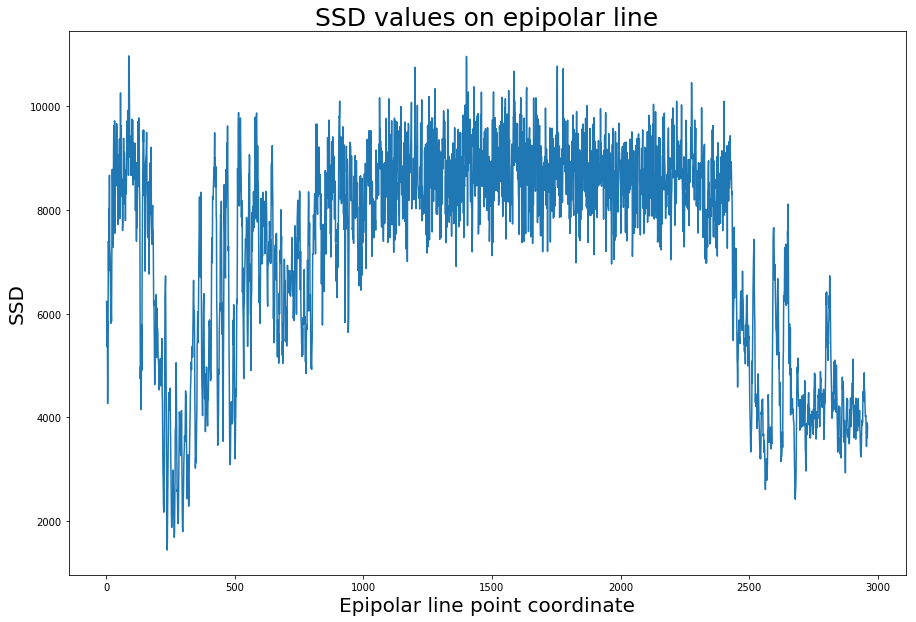

In [8]:
plt.figure(figsize=(15,10))
plt.title("SSD values on epipolar line", fontsize = 25)
plt.xlabel("Epipolar line point coordinate", fontsize = 20)
plt.ylabel("SSD", fontsize = 20)
plt.plot(range(2, imgl.shape[1] - 3), distances)
plt.show()

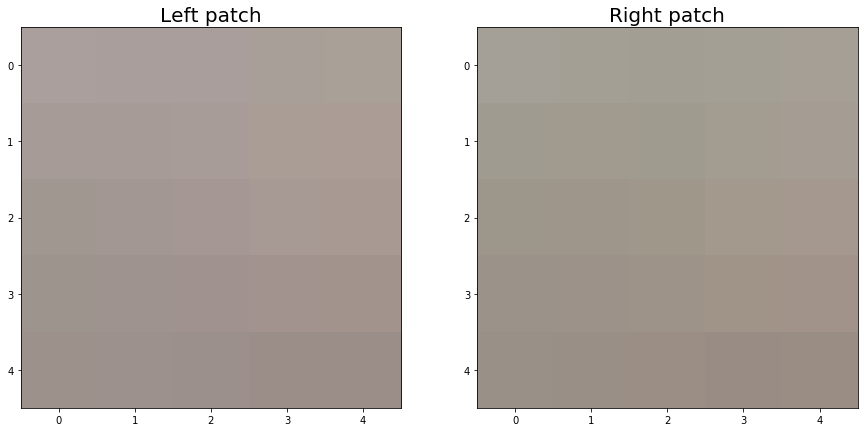

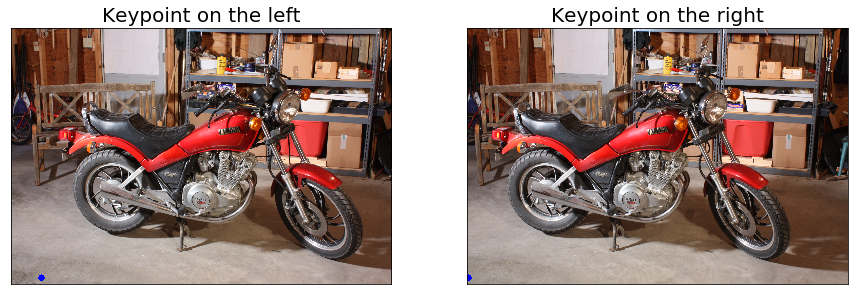

In [9]:
# Display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(_match)
plt.title("Left patch", fontsize = 20)
plt.subplot(122), plt.imshow(patch)
plt.title("Right patch", fontsize = 20)
plt.show()

# Display the kp on left image
disp_keypointl = imgl.copy()
cv2.circle(disp_keypointl, (x_at_min, y), 25, [0,0,255], -1)
plt.figure(figsize=(15, 15))
plt.subplot(121), plt.imshow(disp_keypointl)
plt.title("Keypoint on the left", fontsize = 20), plt.xticks([]), plt.yticks([])
# Display the kp on right image
plt.subplot(122), plt.imshow(disp_keypointr)
plt.title("Keypoint on the right", fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

### Question 2.2 (f)
* Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why.

I found a unique minimal SSD keypoint. From the 5x5 displayed picture as well as the keypoint painted on the bigger images, the the match corresponds to the same object. We should note that it is at a different point because of the uniformity of the floor. As a result the two pixel patches look identical but belong to two different parts of the images.

### Question 2.2 (g)
* Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match?

To deal with multiple matches we could incorporate an additional step on our algorithm. The proposed idea would be to reduce the number of areas where the miss-matching occurs. Such areas are usually smooth in shape. The way to stop this would be to sharpen the image before getting the matches on the keypoints which would reducing smoothing on the image.

### Question 2.2 (h)
* Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?

A way to address this would be use some information on where the matching keypoint was found in the first picture to limit the search region on the second image. As a result this would eliminate any miss-matched points outside the search region. This method would work as long as the difference in the perspective from image to the other is not very big and that the pixel locations of object in one image are close to the location of the same object in the other.